# Imports

In [76]:
import datetime
import pandas_ta as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from backtesting import Backtest, Strategy
from backtesting.test import GOOG

# Load & Process data

In [77]:
data = GOOG

factor = 1_000_000
data['Open'] /= factor
data['High'] /= factor
data['Low'] /= factor
data['Close'] /= factor

# Strategy Class

In [104]:
def indicator(data):
    # % increase in stock over 7 days
    return data.Close.s.pct_change(periods = 7) * 100

class MomentumStrategy(Strategy):

    # Do as much initial computation as possible
    def init(self):
        
        self.pct_change = self.I(indicator, self.data)

    # MB - Any dollar amounts must be divided by factor
    def next(self):
        change = self.pct_change[-1]
        price = self.data.Close[-1]

        if self.position:
            if change < 0:
                self.position.close()

        else:
            if change > 2 and self.pct_change[-2] > 2:
                stop = (1 - (change / 100)) * price
                oneR = abs(price - stop)
                size =  round(1 / oneR * factor)
                self.buy(size=1,sl=stop,tag=oneR)

# Test Run

In [105]:
bt = Backtest(data, MomentumStrategy, cash=100, commission=0.002/factor)

stats = bt.run()
bt.plot(resample=False)

trades = stats['_trades'].drop('ReturnPct', axis=1)
trades.EntryPrice = round(trades.EntryPrice * factor,2)
trades.ExitPrice = round(trades.ExitPrice * factor,2)
trades.PnL = round(trades.PnL,2)
trades.StopLoss = round(trades.StopLoss * factor,2)
trades.oneR = round(trades.oneR * factor,2)

print(stats)
print(trades.to_string())

Start                     2004-08-19 00:00:00
End                       2013-03-01 00:00:00
Duration                   3116 days 00:00:00
Exposure Time [%]                   44.134078
Equity Final [$]                   125.624925
Equity Peak [$]                    126.851725
Return [R]                          25.624925
Buy & Hold Return [%]              703.458242
Return (Ann.) [%]                    2.712528
Volatility (Ann.) [%]                 4.05897
Max. Drawdown [%]                   -7.229853
Avg. Drawdown [%]                   -1.206453
Max. Drawdown Duration     1074 days 00:00:00
Avg. Drawdown Duration      103 days 00:00:00
# Trades                                   90
Win Rate [%]                             40.0
Best Trade [R]                       9.589534
Worst Trade [R]                     -1.571932
Expectancy (mean R)                  0.284721
Max. Trade Duration          55 days 00:00:00
Avg. Trade Duration          14 days 00:00:00
Profit Factor                     

In [61]:
def plot_stats(data_full, stats):
    equity_curve = stats._equity_curve
    aligned_data = data_full.reindex(equity_curve.index)
    
    bt = Backtest(aligned_data, MomentumStrategy, cash=100, commission=0.002)
    bt.plot(results = stats)

In [70]:
plot_stats(data, stats[5])

In [73]:
def plot_full_equity_curve(
    data,
    stats_list,
    warmup_bars,
    lookback_bars):
    
    equity_curves = [x["_equity_curve"].iloc[warmup_bars:] for x in stats_list]
    
    combined = pd.Series(dtype="float64")
    for curve in equity_curves:
        if len(combined) == 0:
            combined = curve["Equity"]/100
        else:
            combined = pd.concat([combined, (curve["Equity"]/100)*combined.iloc[-1]]) 
                                             
    aligned_price_data = data[data.index <= combined.index[-1]].iloc[lookback_bars + warmup_bars:]
    
    fig, ax1 = plt.subplots()
    ax1.plot(combined.index, combined, color="orange")
    ax2 = ax1.twinx()
    ax2.plot(aligned_price_data.index, aligned_price_data.Close*factor)
    
    plt.show()

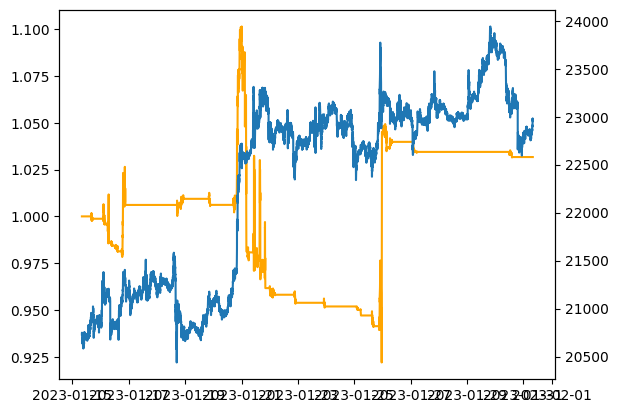

In [74]:
plot_full_equity_curve(data, stats, warmup_bars, lookback_bars)

In [58]:
def plot_period_graph(
    data,
    lookback_bars,
    validation_bars):
    
    ranges = list(range(lookback_bars + warmup_bars, len(data) - validation_bars, validation_bars))
    
    fig, ax = plt.subplots()
    fig.set_figwidth(12)
    
    for i in range(len(ranges)):
        
        training_data = data.iloc[ranges[i]-lookback_bars:ranges[i]]
        validation_data = data.iloc[ranges[i]:ranges[i]+validation_bars]
        
        plt.fill_between(training_data.index,
                        [len(ranges) - i - 0.5]*len(training_data.index),
                        [len(ranges) - i + 0.5]*len(training_data.index),
                         color = "blue"
                        )
        
        plt.fill_between(validation_data.index,
                        [len(ranges) - i - 0.5]*len(validation_data.index),
                        [len(ranges) - i + 0.5]*len(validation_data.index),
                         color = "orange"
                        )
    
    plt.show()

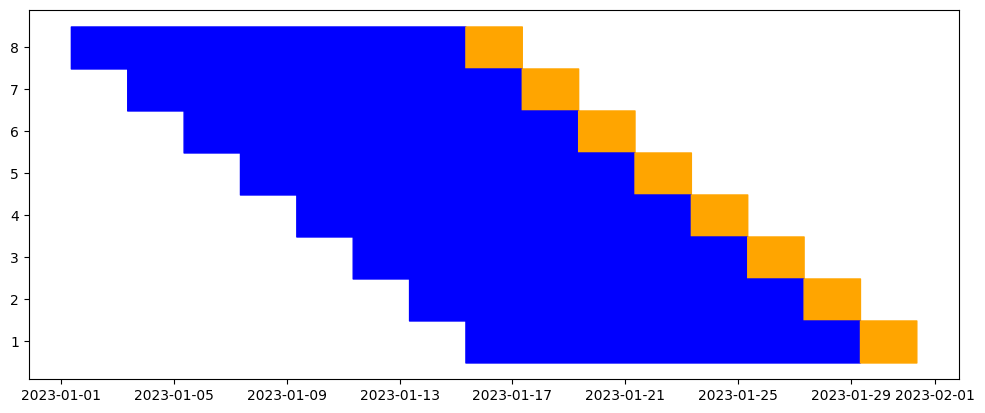

In [72]:
plot_period_graph(data,lookback_bars,validation_bars)